# Digital Services Technical Test - Data Analysis Portion
### Claire Herdeman
### April 9, 2018

In [142]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Loading

#### Datasets

##### CPFB Complaints

My primary dataset is all complaints from 2017 in the Consumer Financial Protection Bureau Complaint Database. This dataset captures complaints filed by consumers against financial institutions, along with the product in question, the issue, and the response by the company. I accessed it using the Socrata API.

Located on the data.gov site here:
https://catalog.data.gov/dataset/consumer-complaint-database/resource/2f297213-7198-4be1-af1e-2d2623e7f6e9 <br>
Can be sourced using their Socrata API here:
https://data.consumerfinance.gov/dataset/Consumer-Complaints/s6ew-h6mp

##### Total Population by Zip Code

The zip code level total population data is drawn from the 2010 census, but was aggregated and hosted as a CSV file in a Splitwise blogpost. 

https://blog.splitwise.com/2013/09/18/the-2010-us-census-population-by-zip-code-totally-free/

##### Zip Code Boundary Areas

The zip code boundaries are provided as a shapefile by the US Census. I used the 2016 boundaries, which can be found at the link below.

https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html

In [143]:
# Define function to load Consumer Financial Protection Bureau data
# using their Socrata API (this is the data.gov piece)

def socrata_load(url, dataset_id, date_range, limit_val, index_col):
	'''
	Basic loading function to call to Socrata Portal and return a dataframe

	Inputs:
		- url (str): url of portal
		- dataset_id (str): 9 digit key to call 
		- date_range (str): defines data range of interest
		- limit_val (int): maximum number of records to pull
		- index_col (str): column to set as index

	Returns a pandas dataframe
	'''
	client = Socrata(url, None)

	results = client.get(dataset_id, where=date_range, 
		limit=limit_val)
	result_df = pd.DataFrame.from_records(results, index=index_col)

	return result_df

In [144]:
# Specify inputs to specific CFPB data for 2017
url = "data.consumerfinance.gov"
dataset_id = "jhzv-w97w"
date_range = "date_received between '2017-01-01T00:00:00.000' and '2017-12-31T00:00:00.000'" 
limit_val = 400000
index_col = 'complaint_id'

In [145]:
# Load dataframe, convert zip code to int to combine with other population info
cfpb_df = socrata_load(url, dataset_id, date_range, limit_val, index_col)
cfpb_df['zip_code'] = pd.to_numeric(cfpb_df['zip_code'], errors = 'coerce').fillna(0).astype(np.int64)

In [146]:
# Load population by zip code from csv
pop_df = pd.read_csv('data/zip_pop_2010.csv')

In [147]:
# Merge population data into cbfp dataframe
full_df = pd.merge(cfpb_df, pop_df, how='inner', left_on = 'zip_code', right_on = 'Zip Code ZCTA')

In [148]:
# Load zip code shape file as GeoDataFrame
geo_zip = gpd.read_file('data/cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp')
geo_zip.rename({'ZCTA5CE10': 'zip_code'}, axis=1, inplace=True)
geo_zip['zip_code'] = pd.to_numeric(geo_zip['zip_code'], errors = 'coerce').fillna(0).astype(np.int64)

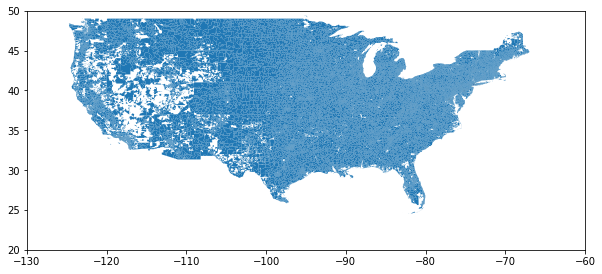

In [149]:
# Plot zip codes for continental US
ax = geo_zip.plot(figsize=(10, 10))
ax.set_xlim(-130, -60)
ax.set_ylim(20, 50)
ax

## Analysis

In [150]:
# Find complaint count by zip code and join to geo_zip
total_count = full_df[['zip_code', 'date_received']].groupby('zip_code').count()
joined = geo_zip.join(total_count, on='zip_code', how='left', lsuffix='l', rsuffix='r')

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


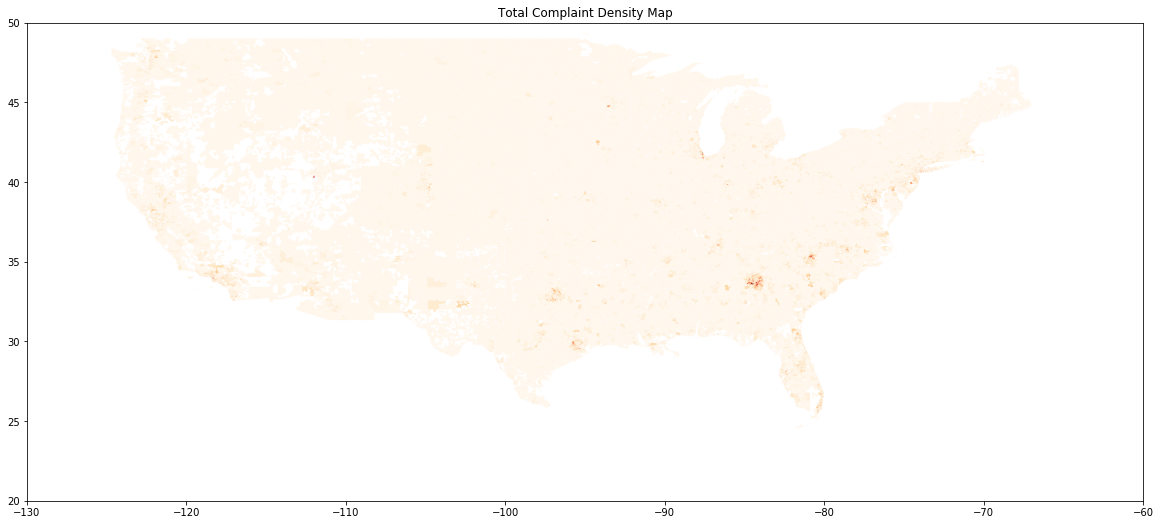

In [151]:
# Create a chloropleth map of complaint volume by zip code in the US
ax = joined.plot(column='date_received', cmap='OrRd', figsize=(20, 20))
plt.title('Total Complaint Density Map')
ax.set_xlim(-130, -60)
ax.set_ylim(20, 50)
ax

This analysis may be more revealing on a state or local rather than national level. However, based on this high level view we can see that, as might be expected, complaint volume is highest in the most populated areas. There is a particuarly notable "hot spot" around Atlanta, and we also generally see more activity on the East Coast than the West Coast. 

We could imagine that these differences arise from differt regional financial institutions that may garner higher or lower numbers of complaints, different levels of awareness of the CFPB complaint sytem, or other underlying factors. 

In [152]:
top5_df = pd.merge(total_count, full_df, how = 'inner', right_on ='zip_code', left_index=True)
top5_df.drop(['company', 'company_public_response',
       'company_response', 'complaint_what_happened',
       'consumer_consent_provided', 'consumer_disputed', 'date_received_y',
       'date_sent_to_company', 'issue', 'product', 'sub_issue',
       'sub_product', 'submitted_via', 'tags', 'timely', 'Zip Code ZCTA'], axis = 1, inplace = True)
top5_df['complaints_per_1k'] = top5_df['date_received_x']/vol_pop_df['2010 Census Population'] * 1000

In [153]:
# Top 5 zip codes by complaint volume
top5_df.drop_duplicates('zip_code').sort_values('date_received_x', ascending=False)[:5]

,date_received_x,state,zip_code,2010 Census Population,complaints_per_1k
29776,174,NY,10016,54183,3.211339
26584,170,GA,30349,67602,2.514718
984,143,GA,30034,43113,3.316865
10610,139,NC,28269,71048,1.956424
67417,133,UT,84005,21410,6.212050


As expected based on a visual inspection of the national map, two of the top 5 zip codes with the highest complaint volume are in Georgia. Both are in the Atlanta Metro Area. Zip code 10016 tops the list and is located in Manhattan, which we might expected to have high complaint density because of it's high population density. Zip Code 28269 is located in Charolette, NC, and zip code 84005 is located in a suburban area outside of Salt Lake. 

In [154]:
# Top 5 zip codes by complaints per 1000 population
# Note that I'm filtering out zip codes with no population recorded
rate_sort = top5_df.drop_duplicates('zip_code').sort_values('complaints_per_1k', ascending=False)
rate_sort[rate_sort['2010 Census Population'] > 0][:5]

,date_received_x,state,zip_code,2010 Census Population,complaints_per_1k
47254,50,GA,31905,9,5555.555556
62689,2,MS,38769,2,1000.000000
50762,10,RI,2861,14,714.285714
114572,1,FL,32399,2,500.000000
87615,9,NJ,7870,26,346.153846


The picture changes significantly when we look at the complaint rate per 1000 population as opposed to total complaint volume, though that is in part due to the low population in the zip codes at the top of the list. It is interesting to note, however, that at least zip code 31905 in Georgia and zip code 02861 in Rhode Island are located on our near military bases. Because military personel living in barracks are not counted in the census, the total population is artificially depressed relative to the volume of complaints received.

To get a more accurate picture it would be useful to set a lower bound population threshold to avoid the low population issue, though it would need to be set such that it didn't preference high population areas too much.

### Extensions

There are of course may possible extentions to this analysis that I am deferring due to testing time constraints. A non-exhaustive list of additional analyses to consider include:

- Complaint volume/rate by financial institution
- Complaint volume/rate by product or issue
- Geographic variation of complaint volume by financial institution/product/issue
- Include additional demographic factors such as median income, home ownership to explore complaint relationship (i.e. do zip codes with lower home ownership rates have more complaints regarding mortgage products?)

Thank you!